In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

from sklearn.model_selection import StratifiedGroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 296
Categorical features: 5


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 370
Categorical Columns: 5


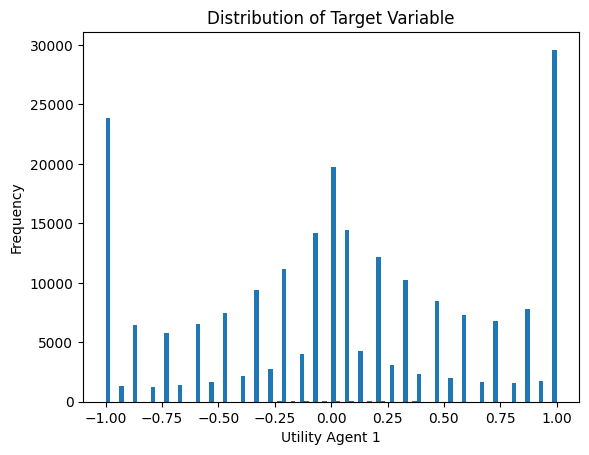

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model

In [6]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
len(numerical_cols): 1370
len(categorical_cols): 5
0:	learn: 0.6018757	test: 0.6025770	best: 0.6025770 (0)	total: 353ms	remaining: 17m 40s
50:	learn: 0.4018008	test: 0.4648439	best: 0.4648439 (50)	total: 16.9s	remaining: 16m 19s
100:	learn: 0.3687724	test: 0.4500960	best: 0.4499791 (99)	total: 35.2s	remaining: 16m 51s
150:	learn: 0.3477459	test: 0.4419998	best: 0.4419998 (150)	total: 53.4s	remaining: 16m 48s
200:	learn: 0.3335840	test: 0.4368472	best: 0.4368472 (200)	total: 1m 10s	remaining: 16m 24s
250:	learn: 0.3221052	test: 0.4336116	best: 0.4335906 (249)	total: 1m 28s	remaining: 16m 10s
300:	learn: 0.3125296	test: 0.4310452	best: 0.4310452 (300)	total: 1m 46s	remaining: 15m 50s
350:	learn: 0.3046322	test: 0.4293379	best: 0.4293340 (348)	total: 2m 4s	remaining: 15m 37s
400:	learn: 0.2981588	test: 0.4277005	best: 0.4277005 (400)	total: 2m 22s	remaining: 15m 22s
450:	learn: 0.2921954	test: 0.4267521	best: 0.4267453 (448)	total: 2m 40s	remaining: 15m 9s
500:	learn: 0.2871623	tes

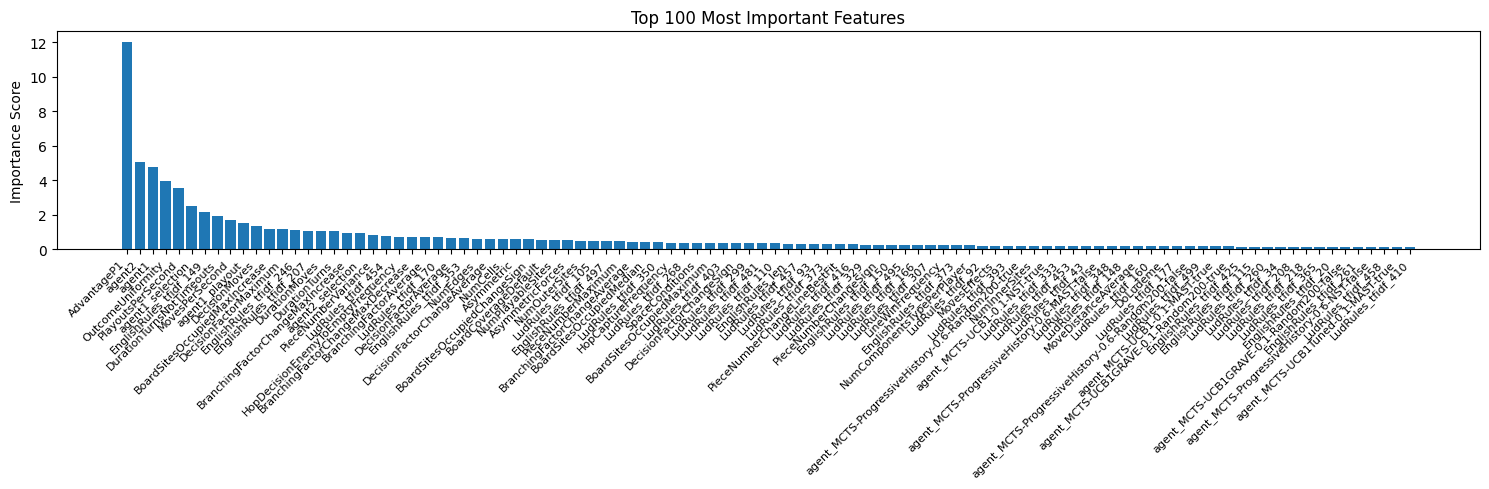

Fold 1 - RMSE: 0.4179278720181287
Fold 2
len(numerical_cols): 1370
len(categorical_cols): 5
0:	learn: 0.5979376	test: 0.6175127	best: 0.6175127 (0)	total: 311ms	remaining: 15m 32s
50:	learn: 0.3968808	test: 0.4848640	best: 0.4848640 (50)	total: 17.4s	remaining: 16m 45s
100:	learn: 0.3662270	test: 0.4717773	best: 0.4717773 (100)	total: 38.4s	remaining: 18m 20s
150:	learn: 0.3462337	test: 0.4636737	best: 0.4636737 (150)	total: 57.4s	remaining: 18m 3s
200:	learn: 0.3326952	test: 0.4601193	best: 0.4601095 (199)	total: 1m 16s	remaining: 17m 41s
250:	learn: 0.3216568	test: 0.4575829	best: 0.4575829 (250)	total: 1m 34s	remaining: 17m 16s
300:	learn: 0.3124794	test: 0.4557335	best: 0.4557335 (300)	total: 1m 52s	remaining: 16m 51s
350:	learn: 0.3049093	test: 0.4539090	best: 0.4539090 (350)	total: 2m 10s	remaining: 16m 26s
400:	learn: 0.2983696	test: 0.4526531	best: 0.4526531 (400)	total: 2m 28s	remaining: 16m
450:	learn: 0.2924129	test: 0.4516417	best: 0.4516417 (450)	total: 2m 46s	remaining: 1

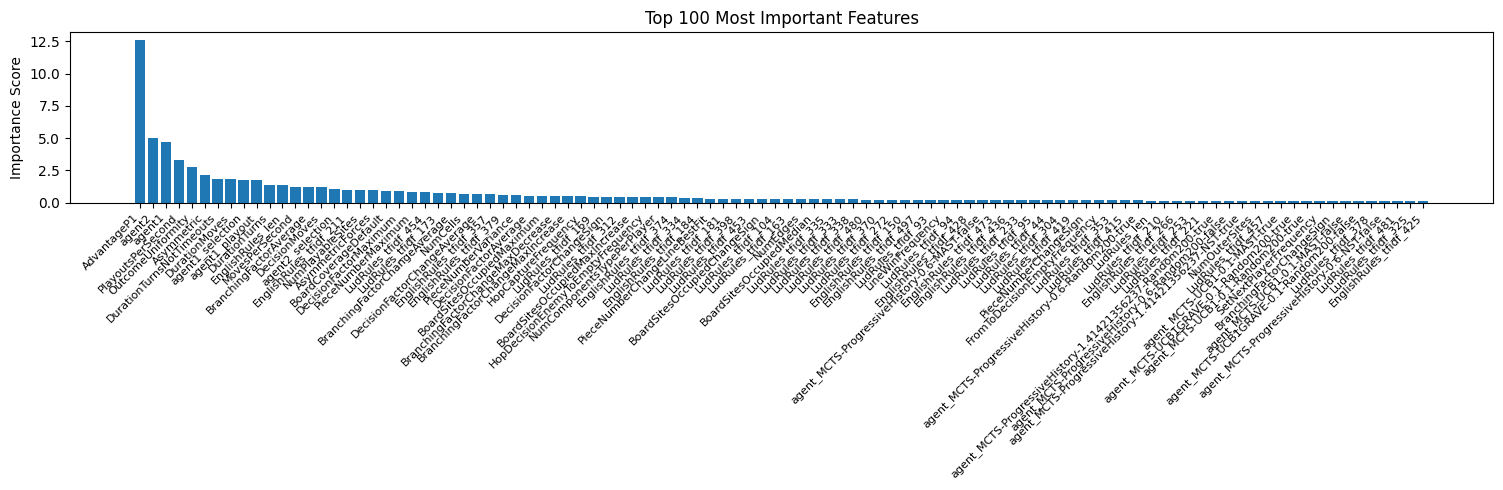

Fold 2 - RMSE: 0.4417712772445931
Fold 3
len(numerical_cols): 1370
len(categorical_cols): 5
0:	learn: 0.6068547	test: 0.5828638	best: 0.5828638 (0)	total: 326ms	remaining: 16m 16s
50:	learn: 0.3990295	test: 0.4533329	best: 0.4533329 (50)	total: 16.7s	remaining: 16m 4s
100:	learn: 0.3683427	test: 0.4401439	best: 0.4401439 (100)	total: 35s	remaining: 16m 44s
150:	learn: 0.3483486	test: 0.4305848	best: 0.4305848 (150)	total: 52.5s	remaining: 16m 29s
200:	learn: 0.3327713	test: 0.4255453	best: 0.4254512 (198)	total: 1m 9s	remaining: 16m 7s
250:	learn: 0.3203944	test: 0.4223942	best: 0.4223942 (250)	total: 1m 26s	remaining: 15m 49s
300:	learn: 0.3112409	test: 0.4206769	best: 0.4206503 (299)	total: 1m 43s	remaining: 15m 31s
350:	learn: 0.3031753	test: 0.4197905	best: 0.4196585 (343)	total: 2m 1s	remaining: 15m 16s
400:	learn: 0.2969123	test: 0.4187990	best: 0.4187990 (400)	total: 2m 19s	remaining: 15m 3s
450:	learn: 0.2908280	test: 0.4174938	best: 0.4174938 (450)	total: 2m 37s	remaining: 14m

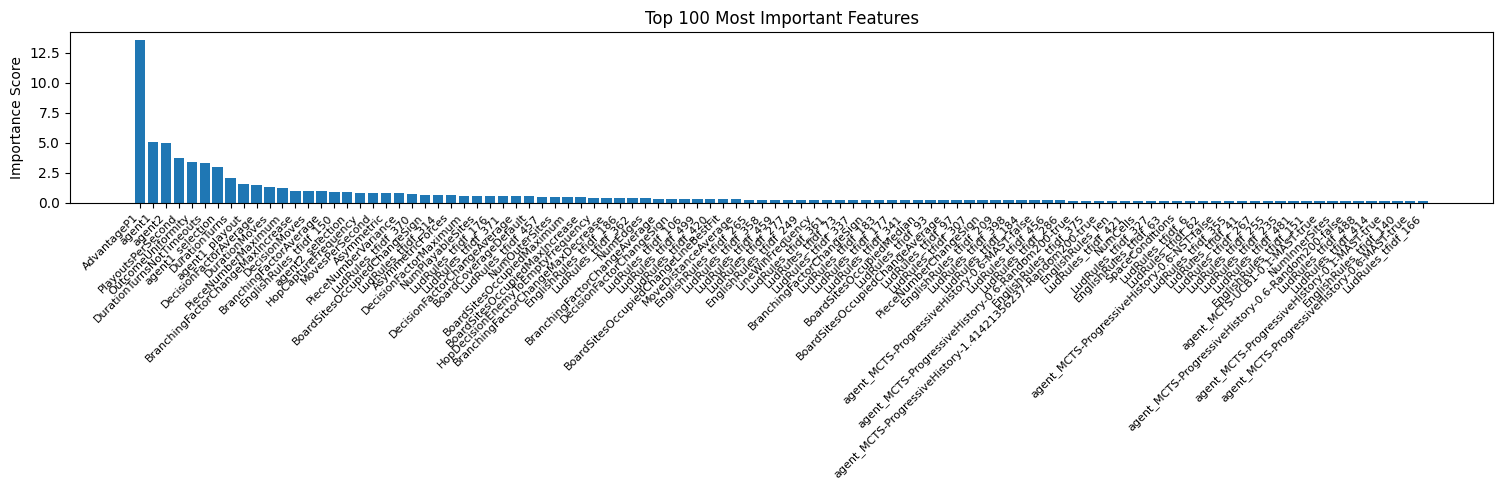

Fold 3 - RMSE: 0.4097966353758969
Fold 4
len(numerical_cols): 1370
len(categorical_cols): 5
0:	learn: 0.5998032	test: 0.6195289	best: 0.6195289 (0)	total: 335ms	remaining: 16m 43s
50:	learn: 0.3990292	test: 0.4834232	best: 0.4834232 (50)	total: 16.4s	remaining: 15m 47s
100:	learn: 0.3680568	test: 0.4671879	best: 0.4671879 (100)	total: 35.9s	remaining: 17m 11s
150:	learn: 0.3471108	test: 0.4558191	best: 0.4558191 (150)	total: 53.5s	remaining: 16m 48s
200:	learn: 0.3326605	test: 0.4510902	best: 0.4510902 (200)	total: 1m 12s	remaining: 16m 43s
250:	learn: 0.3208286	test: 0.4472140	best: 0.4472140 (250)	total: 1m 30s	remaining: 16m 28s
300:	learn: 0.3112897	test: 0.4446675	best: 0.4446675 (300)	total: 1m 47s	remaining: 16m 7s
350:	learn: 0.3031426	test: 0.4421880	best: 0.4421880 (350)	total: 2m 6s	remaining: 15m 54s
400:	learn: 0.2964856	test: 0.4407580	best: 0.4407580 (400)	total: 2m 24s	remaining: 15m 39s
450:	learn: 0.2912029	test: 0.4397297	best: 0.4397297 (450)	total: 2m 44s	remaining

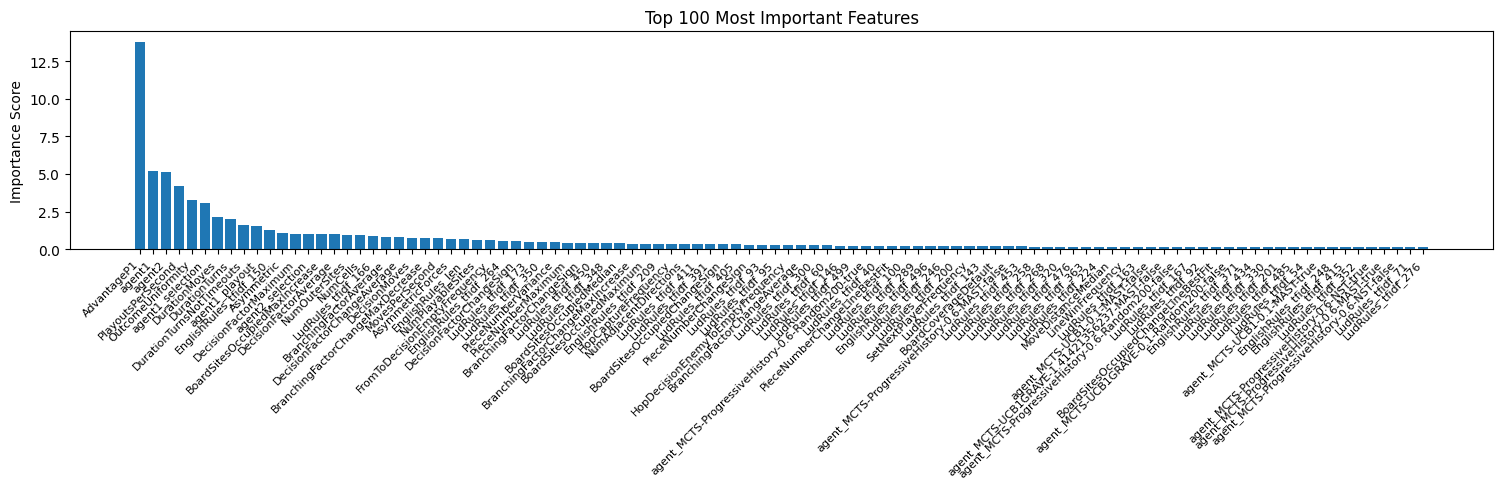

Fold 4 - RMSE: 0.42832642545175803
Fold 5
len(numerical_cols): 1370
len(categorical_cols): 5
0:	learn: 0.5998456	test: 0.6133166	best: 0.6133166 (0)	total: 331ms	remaining: 16m 31s
50:	learn: 0.4034216	test: 0.4897564	best: 0.4893628 (47)	total: 16.5s	remaining: 15m 55s
100:	learn: 0.3710832	test: 0.4757395	best: 0.4757395 (100)	total: 34.2s	remaining: 16m 21s
150:	learn: 0.3508977	test: 0.4696881	best: 0.4696881 (150)	total: 51.3s	remaining: 16m 8s
200:	learn: 0.3366024	test: 0.4658056	best: 0.4658056 (200)	total: 1m 8s	remaining: 15m 54s
250:	learn: 0.3253089	test: 0.4629773	best: 0.4629773 (250)	total: 1m 26s	remaining: 15m 50s
300:	learn: 0.3163471	test: 0.4607666	best: 0.4607666 (300)	total: 1m 44s	remaining: 15m 41s
350:	learn: 0.3086079	test: 0.4589644	best: 0.4589644 (350)	total: 2m 2s	remaining: 15m 23s
400:	learn: 0.3015906	test: 0.4575670	best: 0.4575670 (400)	total: 2m 19s	remaining: 15m 4s
450:	learn: 0.2960460	test: 0.4565575	best: 0.4565575 (450)	total: 2m 37s	remaining:

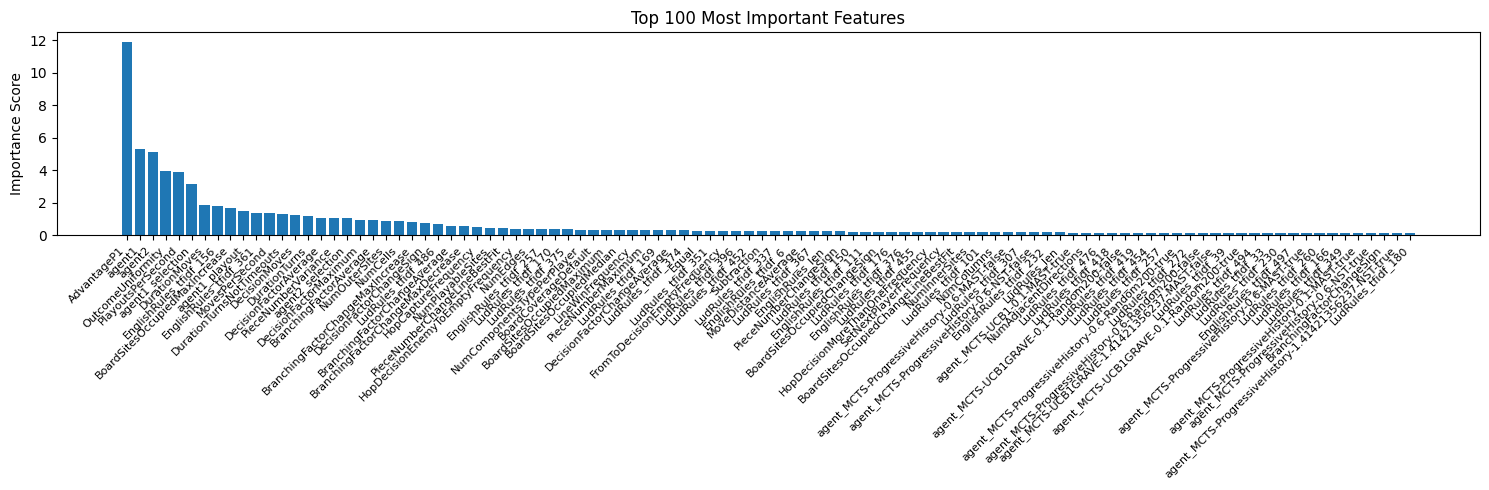

Fold 5 - RMSE: 0.4487667489565549
List of oof scores: [0.4179278720181287, 0.4417712772445931, 0.4097966353758969, 0.42832642545175803, 0.4487667489565549]
Average oof score: 0.42931779180938634


In [8]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        num_folds=5,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=2112, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }

        # # Text processing parameters to mimic TF-IDF
        'tokenizers': [{
            'tokenizer_id': 'Space',
            'separator_type': 'ByDelimiter',
            'delimiter': ' '
        }],
        'dictionaries': [{
            'dictionary_id': 'NgramDict',
            'max_dictionary_size': '500',  # Match max_features=500
            'occurrence_lower_bound': '3',
            'gram_order': '3',  # Maximum n-gram size
            'min_gram_order': '2'  # Minimum n-gram size
        }],
        'feature_calcers': [{
            'calcer_type': 'BoW',  # Most similar to TF-IDF
            'dictionary_id': 'NgramDict'
        }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Add TF-IDF features for text columns
        new_numerical_cols = list()
        for col in text_cols:
            tfidf = TfidfVectorizer(max_features=500, ngram_range=(2,3))
            tfidf_feats = tfidf.fit_transform(X_train[col]).toarray()
            
            # Create new column names
            new_cols = [f"{col}_tfidf_{i}" for i in range(tfidf_feats.shape[1])]
            new_numerical_cols.extend(new_cols)
            
            # Add TF-IDF features to training data
            X_train = pd.concat([
                X_train, 
                pd.DataFrame(tfidf_feats, columns=new_cols, index=X_train.index)
                ], 
                axis=1
            )
            
            # Transform validation data using fitted TF-IDF
            val_tfidf = tfidf.transform(X_valid[col]).toarray()
            X_valid = pd.concat([
                X_valid,
                pd.DataFrame(val_tfidf, columns=new_cols, index=X_valid.index)
                ],
                axis=1
            )
        
        # Add new column names to numerical features
        _numerical_cols = numerical_cols + new_numerical_cols
        
        print("len(numerical_cols):", len(_numerical_cols))
        print("len(categorical_cols):", len(categorical_cols))

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[_numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            data=X_valid[_numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        plot_feature_importance(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores

# Call the function
trained_models, oof, oof_scores = train_models(
    df_train, numerical_cols, categorical_cols, text_cols=["EnglishRules", "LudRules"]
)

# save oof predictions
#oof.to_csv(path_results / 'oof_catboost.csv', index=False)

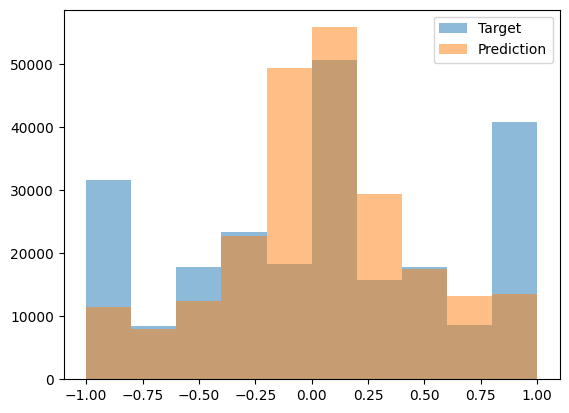

In [9]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [22]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [23]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [ ]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

In [ ]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [26]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***
